In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Data visualization

from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

In [2]:
df = pd.read_csv("./data/data.csv")

In [4]:
df.shape

(6819, 96)

In [3]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [5]:
#removing space in column naming
df.columns = df.columns.str.strip()

In [6]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [7]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [21]:
#Net Income Flag is 1 for all rows, so we delete this column
df.drop(columns=['Net Income Flag'], inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

- Looks like the data has lots of correleted columns looking at the names of the variables.
- 2 categorical variables: Liability-Assets Flag 

In [23]:
#no missing values
(df.isna().sum()>0).sum()

0

In [24]:
#no duplicated rows
df.duplicated().sum()

0

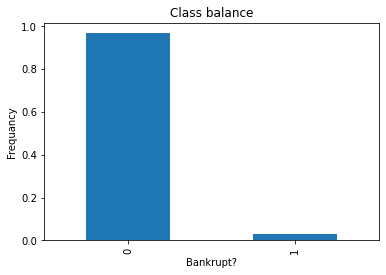

In [29]:
#checking the distribution of the target variable
df['Bankrupt?'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("Bankrupt?")
plt.ylabel("Frequancy")
plt.title("Class balance")
plt.show()

We have imbalance class, need to consider that when building a model

In [52]:
independent_variable = df.drop(['Bankrupt?'], axis=1)
target_variable = df[['Bankrupt?']]

importances_mutual = mutual_info_classif(independent_variable,pd.Series.ravel(target_variable))
importances_mutual = pd.Series(importances_mutual,independent_variable.columns[0:len(independent_variable.columns)])
importances_mutual = pd.DataFrame({'features':importances_mutual.index, 'importance':importances_mutual.values})

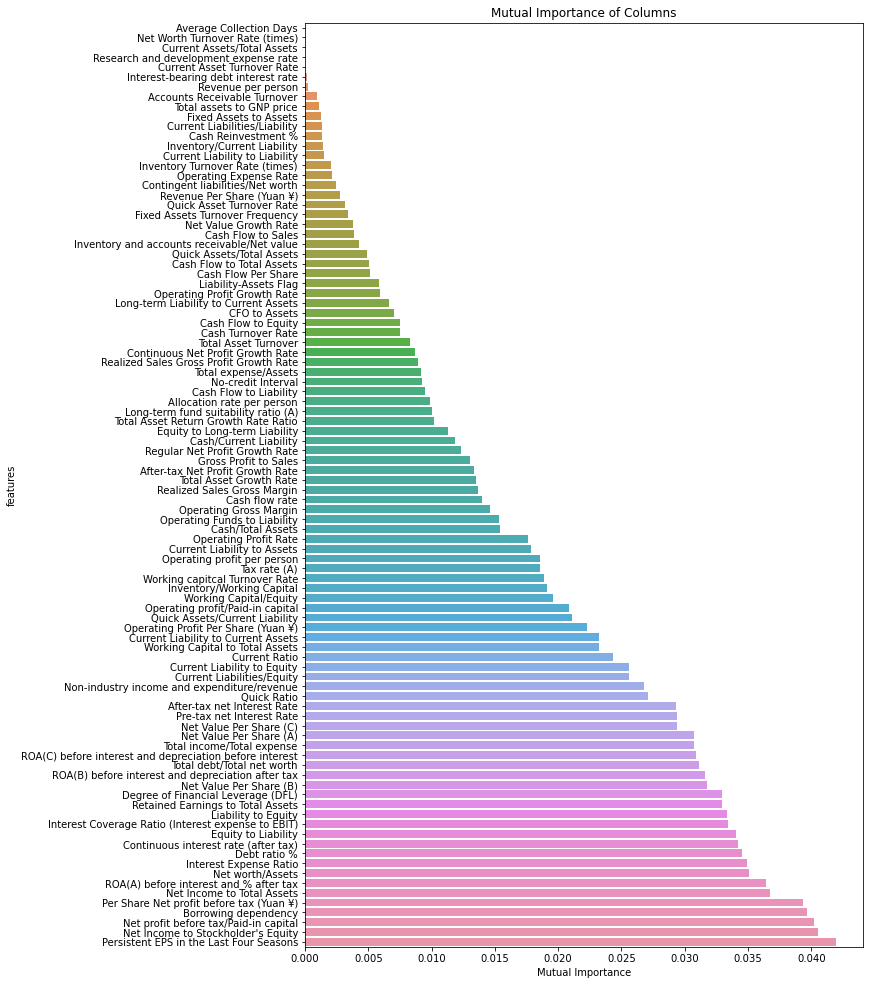

In [53]:
# Mutual information
plt.figure(figsize=(10, 17))
sns.barplot(data = importances_mutual, y = "features", x = "importance",order=importances_mutual.sort_values('importance').features)
plt.xlabel("Mutual Importance")
plt.title("Mutual Importance of Columns")
plt.show()

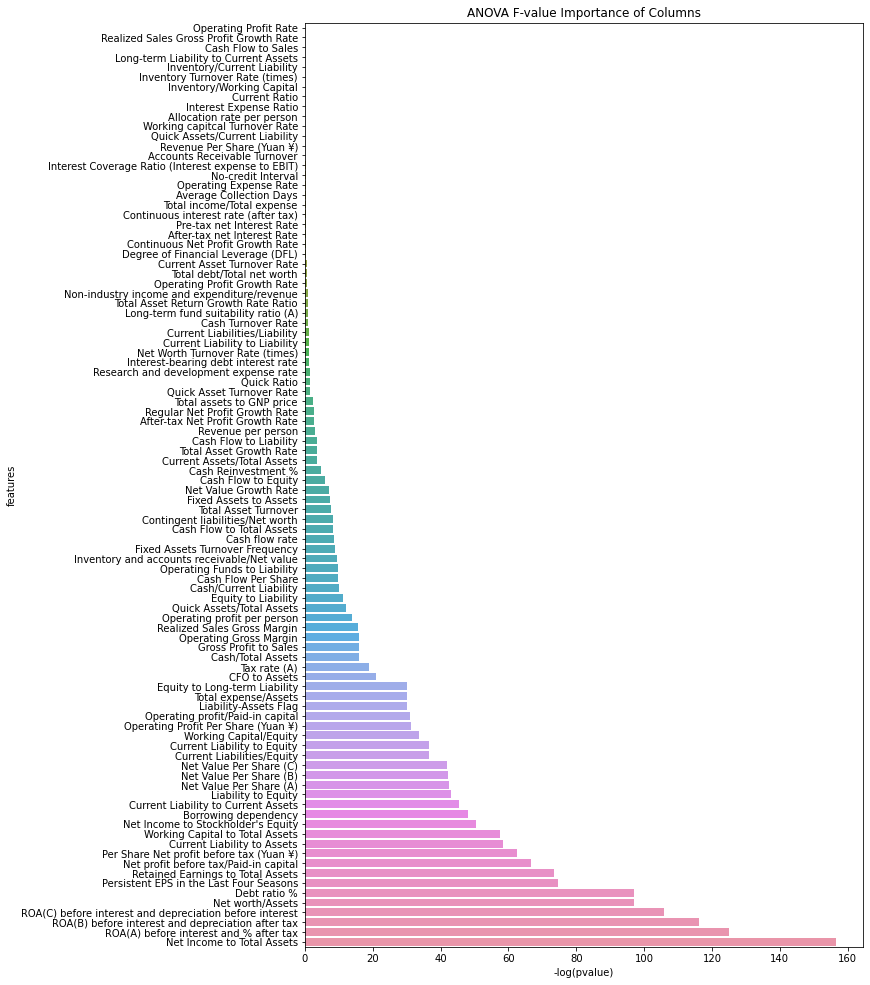

In [54]:
importances_f = f_classif(independent_variable,pd.Series.ravel(target_variable))
importances_f = pd.Series(-np.log10(importances_f[1]),independent_variable.columns[0:len(independent_variable.columns)])
importances_f = pd.DataFrame({'features':importances_f.index, 'importance':importances_f.values})

plt.figure(figsize=(10, 17))
sns.barplot(data = importances_f, y = "features", x = "importance", order=importances_f.sort_values('importance').features)
plt.xlabel("-log(pvalue)")
plt.title("ANOVA F-value Importance of Columns")
plt.show()

In [60]:
# Lets select top 10 columns for EDA and Modelling
selected_columns_set_mutual = np.array(importances_mutual.nlargest(15,'importance').features)
selected_columns_set_f = np.array(importances_f.nlargest(15,'importance').features)

In [61]:
selected_columns = [*selected_columns_set_mutual , *selected_columns_set_f]
selected_columns = np.unique(selected_columns)

In [66]:
selected_columns

array(['Borrowing dependency', 'Continuous interest rate (after tax)',
       'Current Liability to Assets',
       'Current Liability to Current Assets', 'Debt ratio %',
       'Equity to Liability',
       'Interest Coverage Ratio (Interest expense to EBIT)',
       'Interest Expense Ratio', 'Liability to Equity',
       "Net Income to Stockholder's Equity", 'Net Income to Total Assets',
       'Net profit before tax/Paid-in capital', 'Net worth/Assets',
       'Per Share Net profit before tax (Yuan ¥)',
       'Persistent EPS in the Last Four Seasons',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'ROA(C) before interest and depreciation before interest',
       'Retained Earnings to Total Assets',
       'Working Capital to Total Assets'], dtype='<U55')

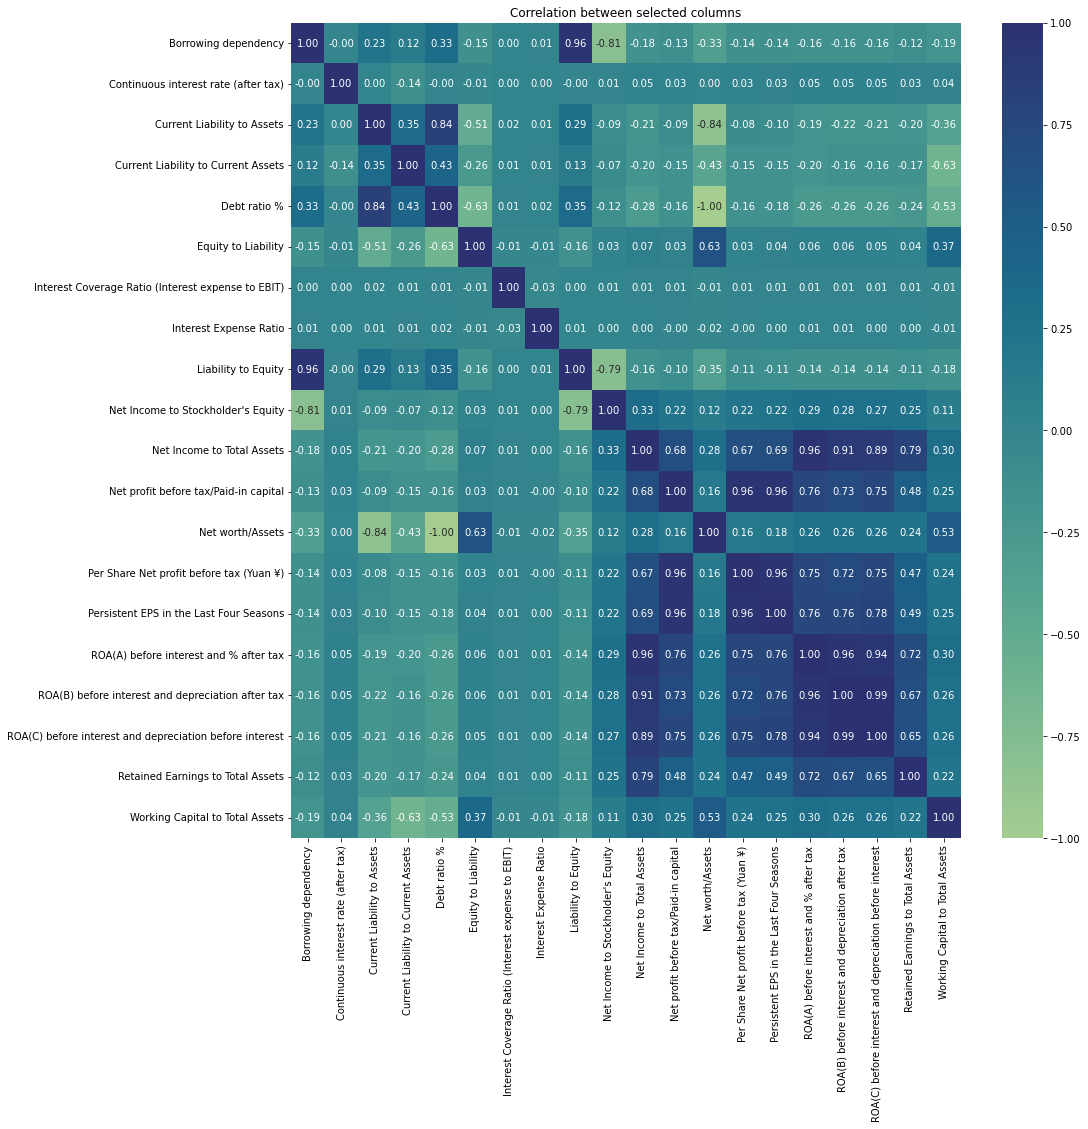

In [65]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[selected_columns].corr(),cmap="crest",annot=True, fmt=".2f")
plt.title("Correlation between selected columns")
plt.show()

In [71]:
selected_columns = ['Borrowing dependency',
                    'Continuous interest rate (after tax)',
                    'Current Liability to Assets',
                    'Current Liability to Current Assets', 
                    'Equity to Liability',
                    'Interest Coverage Ratio (Interest expense to EBIT)',
                    'Interest Expense Ratio', 
                    'Net Income to Total Assets']

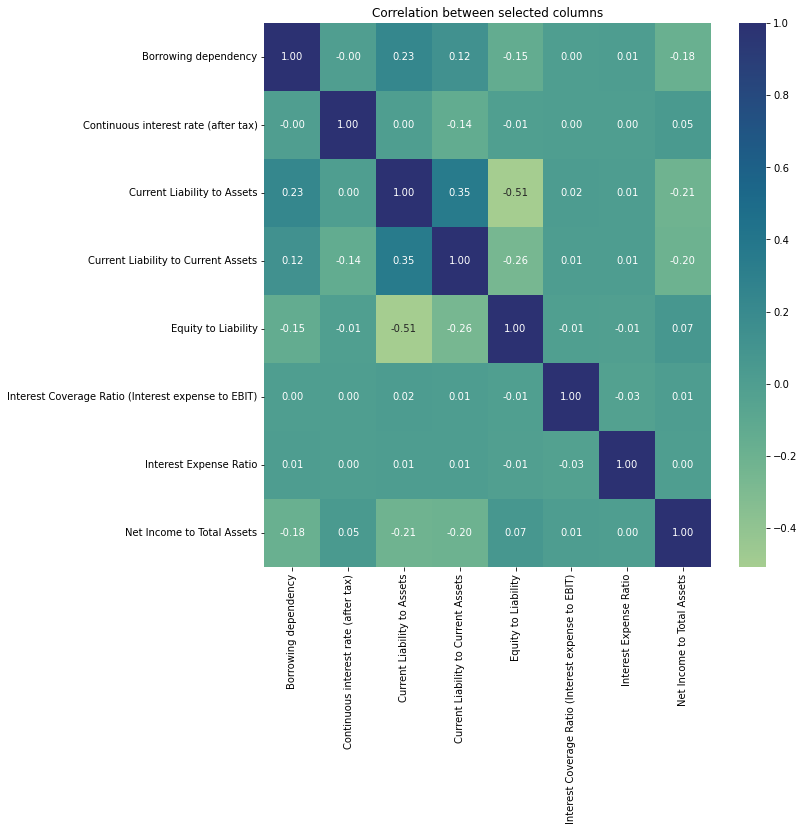

In [73]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[selected_columns].corr(), cmap="crest", annot=True, fmt=".2f")
plt.title("Correlation between selected columns")
plt.show()